In [9]:
import numpy as np
import netket as nk
from itertools import product
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import mpltern
from tqdm import tqdm
from Hamiltonians import Kitaev
from pathlib import Path
import json

In [2]:
def compute_energy_gap(hamiltonian):
    evals = nk.exact.lanczos_ed(hamiltonian, k=2, compute_eigenvectors=False)
    return evals[1] - evals[0]

def compute_kitaev_phase_diagram(kitaev_graph, kitaev_hi, J_scale):
    J_product = np.array(list(product(J_scale, repeat=3)))
    J_product /= np.sum(J_product, axis=1, keepdims=True)
    J_product = np.unique(J_product, axis=0)
    gaps = np.zeros(len(J_product))
    for i, J_vec in tqdm(enumerate(J_product)):
        hamiltonian = Kitaev(kitaev_hi, graph=kitaev_graph, J=-J_vec)
        gaps[i] = compute_energy_gap(hamiltonian)
    return J_product, gaps

In [5]:
image_path = Path('./images/4-KitaevPhaseDiagram')
extent = [3, 3]
dJ, J0 = 0.2, 0.05 # 121
J = np.arange(J0, 1, dJ)
kitaev = nk.graph.KitaevHoneycomb(extent=extent, pbc=True)
hi_kitaev = nk.hilbert.Spin(s=1/2, N=kitaev.n_nodes)
kitaev.n_nodes # 492 it

18

In [6]:
J_map, energy_gaps = compute_kitaev_phase_diagram(kitaev, hi_kitaev, J)

121it [10:51:49, 323.22s/it]


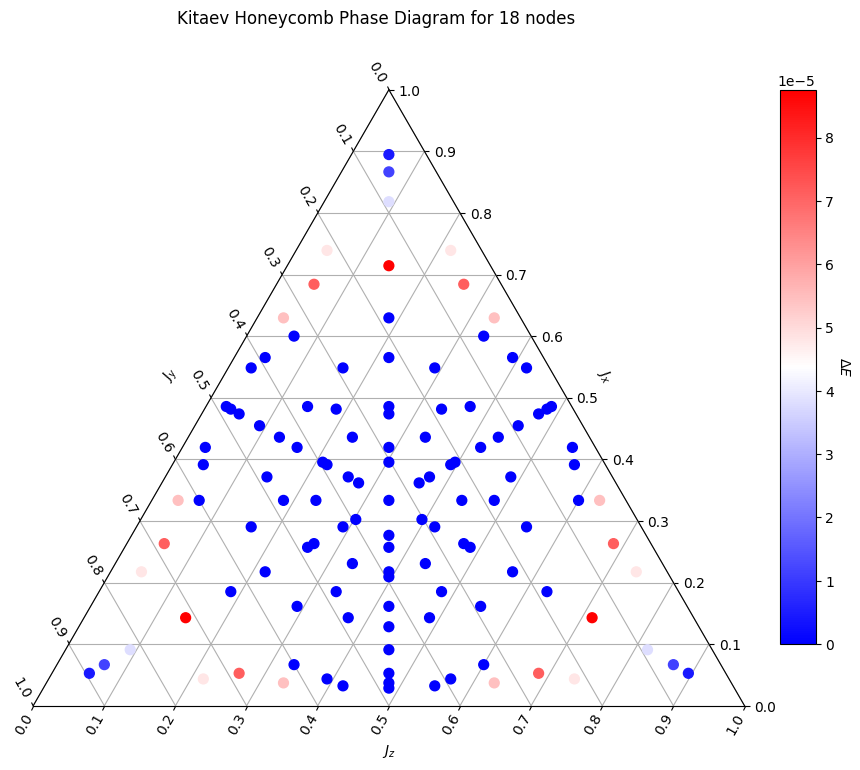

In [7]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection='ternary')
levels = np.linspace(min(energy_gaps), max(energy_gaps), 1000)
pc = ax.scatter(J_map[:, 0], J_map[:, 1], J_map[:, 2], c=energy_gaps, s=50, cmap='bwr', zorder=3)
# pc = ax.tripcolor(J_map[:, 0], J_map[:, 1], J_map[:, 2], energy_gaps, shading='gouraud', vmin=min(energy_gaps), vmax=max(energy_gaps), rasterized=False, cmap='Blues', zorder=2)
cax = ax.inset_axes([1.05, 0.1, 0.05, 0.9], transform=ax.transAxes)
colorbar = fig.colorbar(pc, cax=cax)
colorbar.set_label('$\Delta E$', rotation=270, va="baseline")
for axes_axis, label, set_label_ in zip([ax.taxis, ax.laxis, ax.raxis], 
                                       ['$J_x$', '$J_y$', '$J_z$'],
                                       [ax.set_tlabel, ax.set_llabel, ax.set_rlabel]):
    set_label_(label)
    axes_axis.set_label_position("tick1")
    axes_axis.set_major_locator(MultipleLocator(0.10))
ax.grid()
fig.suptitle(f'Kitaev Honeycomb Phase Diagram for {kitaev.n_nodes} nodes');

In [8]:
fig.savefig(image_path / f'PhaseDiagramN{kitaev.n_nodes}.png')

In [13]:
sim_path = Path('./Simulations/4-KitaevPhaseDiagram')
with open(sim_path / f'PhaseDiagramN{kitaev.n_nodes}.json', 'w') as sim_file:
    json.dump({'J_map': J_map.tolist(), 'energy_gaps': energy_gaps.tolist()}, sim_file)